<a href="https://colab.research.google.com/github/vinithreddybanda/Deep-Learning/blob/main/CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.0452 - loss: 4.3137 - val_accuracy: 0.0930 - val_loss: 3.9000
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0960 - loss: 3.8797 - val_accuracy: 0.1256 - val_loss: 3.7589
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1199 - loss: 3.7514 - val_accuracy: 0.1310 - val_loss: 3.6629
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1405 - loss: 3.6116 - val_accuracy: 0.1572 - val_loss: 3.5758
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1530 - loss: 3.5367 - val_accuracy: 0.1618 - val_loss: 3.5147
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1662 - loss: 3.4713 - val_accuracy: 0.1702 - val_loss: 3.4733
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.1753 - loss: 3.4247 - val_accuracy: 0.1720 - val_loss: 3.4795
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.1792 - loss: 3.3867

Text(0.5, 1.0, 'CIFAR-100 Confusion')

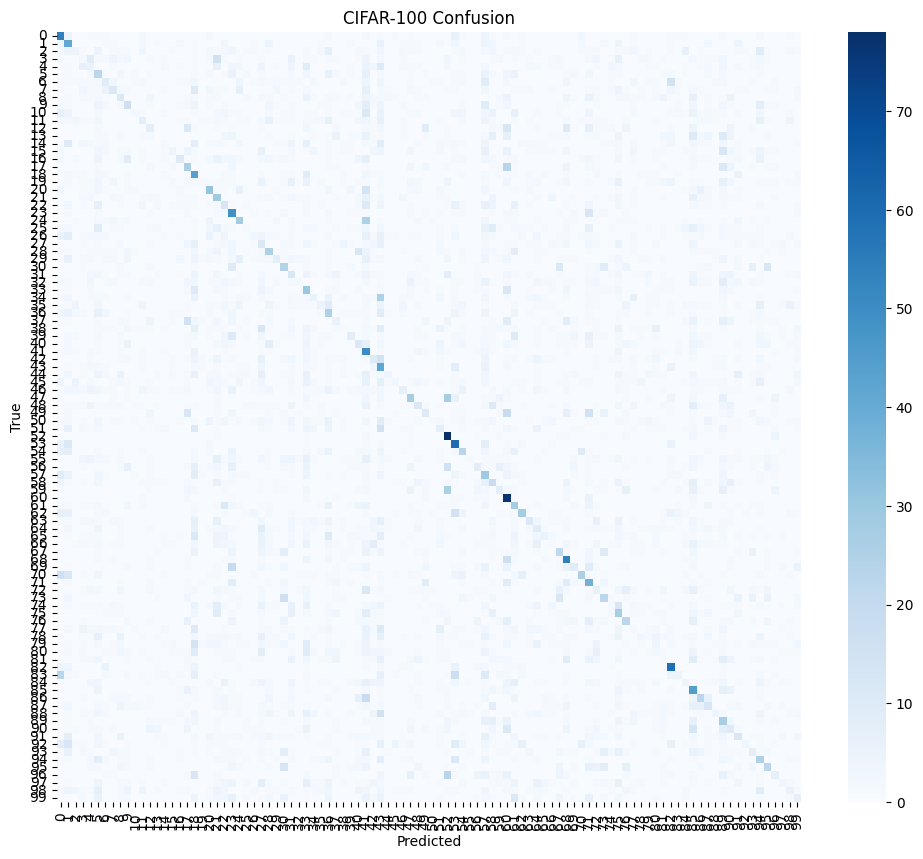

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, random_split
import logging
import itertools

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Data Augmentation and Normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.9 * len(train_set))
val_size = len(train_set) - train_size
train_sub, val_sub = random_split(train_set, [train_size, val_size])

labels = train_set.classes

# Define Feedforward Neural Network
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim=32*32*3, hidden_layers=[128, 64, 32], num_classes=10, activation='relu', dropout=0.3):
        super(FeedforwardNN, self).__init__()
        layers = []
        prev_size = input_dim
        act_fn = nn.ReLU() if activation == 'relu' else nn.Sigmoid()

        for h in hidden_layers:
            layers.append(nn.Linear(prev_size, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(act_fn)
            layers.append(nn.Dropout(dropout))
            prev_size = h

        layers.append(nn.Linear(prev_size, num_classes))
        self.network = nn.Sequential(*layers)
        self._init_weights()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

    def _init_weights(self):
        for m in self.network:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

# Function to Get Optimizer
def get_optimizer(model, opt_type='adam', lr=1e-3, weight_decay=0):
    optimizers = {
        'sgd': optim.SGD(model.parameters(), lr=lr),
        'momentum': optim.SGD(model.parameters(), lr=lr, momentum=0.9),
        'nesterov': optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True),
        'rmsprop': optim.RMSprop(model.parameters(), lr=lr),
        'adam': optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay),
        'nadam': optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    }
    return optimizers[opt_type]

# Training Function
def train(model, train_loader, val_loader, optimizer, loss_fn, epochs=10):
    model.to(DEVICE)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            optimizer.zero_grad()
            preds = model(imgs)
            loss = loss_fn(preds, lbls)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} - Avg Loss: {total_loss/len(train_loader):.4f}")
    return evaluate(model, val_loader)

# Evaluation Function
def evaluate(model, loader):
    model.to(DEVICE)
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            preds = model(imgs)
            _, pred_classes = torch.max(preds, 1)
            total += lbls.size(0)
            correct += (pred_classes == lbls).sum().item()
    acc = round(100 * correct / total, 2)
    return acc

# Confusion Matrix Plot
def plot_cm(model, loader):
    model.eval()
    preds_list, lbls_list = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(DEVICE)
            preds = model(imgs)
            _, pred_classes = torch.max(preds, 1)
            preds_list.extend(pred_classes.cpu().numpy())
            lbls_list.extend(lbls.numpy())
    cm = confusion_matrix(lbls_list, preds_list)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Run Experiments
hyperparams = itertools.product(
    [5, 10],  # epochs
    [[128, 64, 32], [256, 128, 64]],  # hidden layers
    ['sgd', 'adam'],  # optimizers
    [1e-3, 1e-4],  # learning rates
    [0, 0.0005]  # weight decay
)

best_acc = 0
best_config = None
for ep, hl, opt, lr, wd in hyperparams:
    train_loader = DataLoader(train_sub, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=64, shuffle=False)
    model = FeedforwardNN(hidden_layers=hl).to(DEVICE)
    optimizer = get_optimizer(model, opt, lr, wd)
    acc = train(model, train_loader, val_loader, optimizer, nn.CrossEntropyLoss(), ep)
    if acc > best_acc:
        best_acc = acc
        best_config = (ep, hl, opt, lr, wd)
    print(f"Config: {ep} epochs, {hl} layers, {opt} optimizer, lr={lr}, wd={wd} => Accuracy: {acc}%")

print(f"Best Config: {best_config} with Accuracy: {best_acc}%")